 ## HW3 - EuroSAT Land Use and Land Cover Classification using Deep Learning

Nissim Lebovits
March 17, 2023

In this homework your task is to implement traditional and DL models to solve a typical problem in satellite imaging  using a benchmark dataset.

### Notes:

For this assignment, I have used a number of additional sources, including [this Kaggle tutorial](https://www.kaggle.com/code/nilesh789/land-cover-classification-with-eurosat-dataset), ChatGPT, and Github Copilot.

### S1: Reading and Preparing the Data

#### Importing the Data

First, we'll import our libraries and read in our data.

In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

labels = os.listdir(url)

print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


#### Exploring the Data

We can take a look at the data to see the distribution by class.

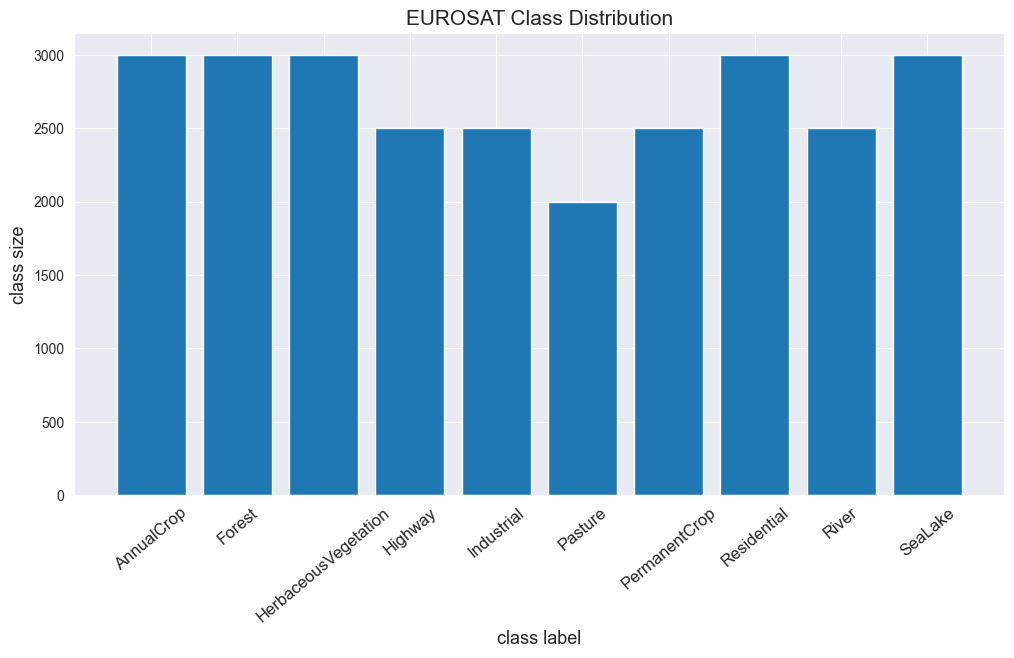

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(url, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

We can also visualize sample images from each class.

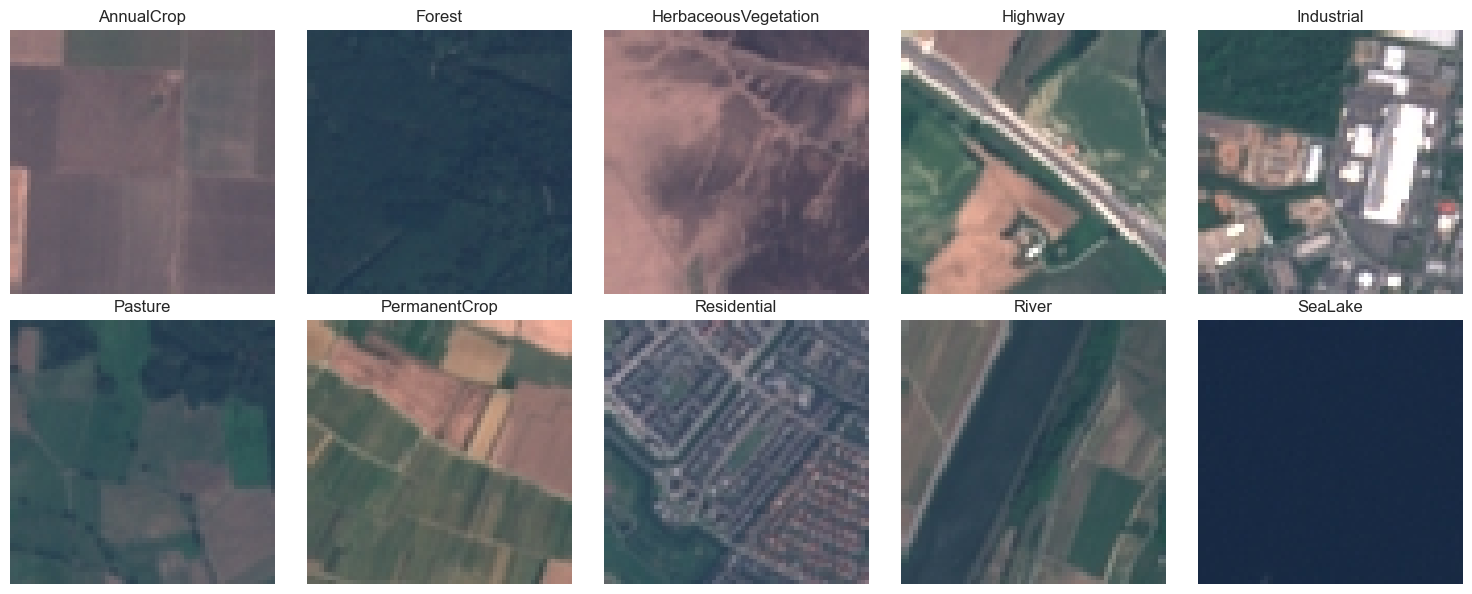

In [4]:
# plot one image from each class in a 2x5 grid
plt.figure(figsize=(15, 6))

for i, l in enumerate(labels):
    plt.subplot(2, 5, i+1)
    img = PIL.Image.open(os.path.join(url, l, os.listdir(os.path.join(url, l))[0]))
    plt.imshow(img)
    plt.title(l)
    plt.axis('off')

plt.tight_layout()
plt.show()

Now we'll import the data and split it into training and testing sets.

C:\Users\Nissim\Desktop\Spring 2023\Remote Sensing\MUSA-650_Spring2023\venv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


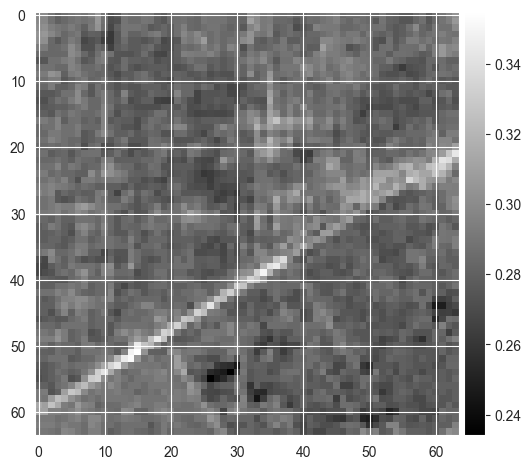

In [5]:
import os
import imageio.v2 as imageio
import numpy as np
from skimage import io, color

# Load an example image
img = io.imread("C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750/Forest/Forest_28.jpg")

# Check if the image is already grayscale
if len(img.shape) == 2 or np.allclose(img[...,0], img[...,1]) and np.allclose(img[...,0], img[...,2]):
    print('Image is already grayscale')
else:
    # Convert the image to grayscale using rgb2gray()
    gray_img = color.rgb2gray(img)
    io.imshow(gray_img, cmap='gray')
    io.show()

In [6]:
import os
import imageio.v2 as imageio
import numpy as np
from skimage import color

# Define the subfolder names
subfolders = ['Residential', 'Industrial', 'Forest']

# Initialize empty lists for images and labels
images = []
labels = []

# Loop over subfolders
for subfolder in subfolders:
    # Get list of image filenames in the current subfolder
    subfolder_path = os.path.join(url, subfolder)
    image_filenames = os.listdir(subfolder_path)

    # Load and append each image to images list
    for image_filename in image_filenames:
        image_path = os.path.join(subfolder_path, image_filename)
        image = imageio.imread(image_path)
        # Convert image to grayscale
        gray_image = color.rgb2gray(image)
        images.append(gray_image)
        labels.append(subfolder)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

images.shape

(8500, 64, 64)

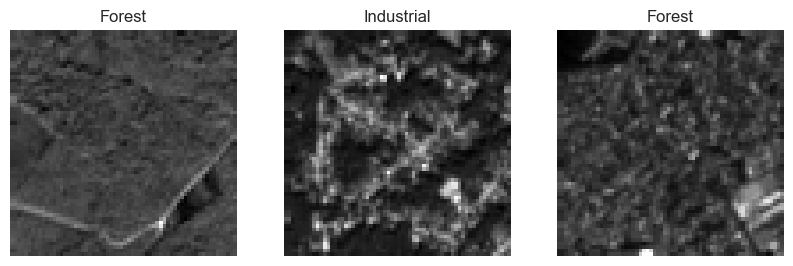

In [7]:
# print three random images from images with their labels
plt.figure(figsize=(10, 10))
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[random.randint(0, len(images))], cmap="gray")
    plt.title(labels[random.randint(0, len(labels))])
    plt.axis("off")

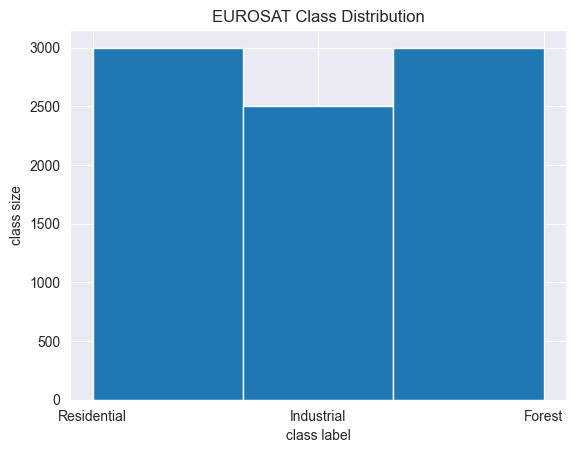

In [8]:
# plot a histogram of the distribution of labels in images
plt.hist(labels, bins=3)
plt.xticks([0, 1, 2], subfolders)
plt.xlabel('class label')
plt.ylabel('class size')
plt.title('EUROSAT Class Distribution');

Now we'll flatten the images.

In [9]:
# flatten images
images = images.reshape(images.shape[0], -1)

# print shape of images
images.shape

(8500, 4096)

#### Splitting the Data

We can now split the data into training and testing sets. We want a 60-40 split.

In [10]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.4, random_state=42)

### S2: Binary Classifiers

SVM classifier for classes ('Forest', 'Industrial') Accuracy: 0.997246443322625
False label: Forest
True label: Industrial


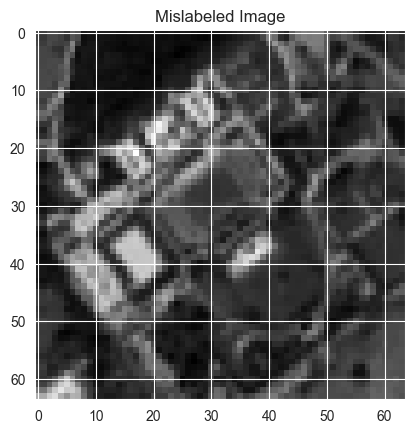

SVM classifier for classes ('Forest', 'Residential') Accuracy: 0.9558149228845352
False label: Forest
True label: Residential


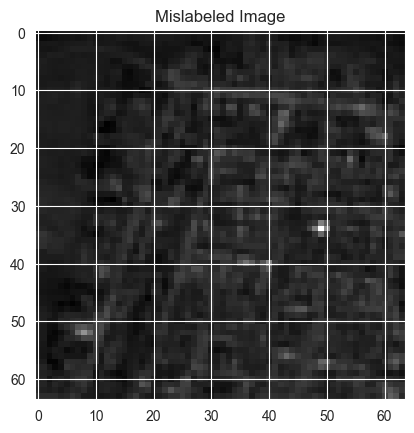

SVM classifier for classes ('Industrial', 'Residential') Accuracy: 0.7421242124212422
False label: Industrial
True label: Residential


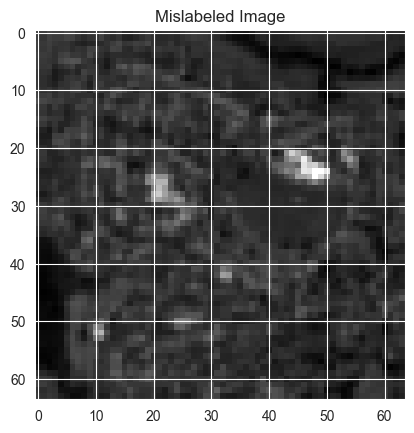

In [11]:
from itertools import combinations
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a list of class combinations
class_combinations = combinations(set(labels), 2)

# Train and evaluate each binary SVM classifier
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    
    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1)
    svm.fit(images_train_filtered, labels_train_filtered)
    
    # Evaluate the performance of the binary SVM classifier on the filtered test data
    y_pred = svm.predict(images_test_filtered)
    accuracy = accuracy_score(labels_test_filtered, y_pred)
    
    # Print the accuracy score for the current binary SVM classifier
    print("SVM classifier for classes", classes, "Accuracy:", accuracy)

    # Find a mislabeled image
    misclassified_idx = np.where(y_pred != labels_test_filtered)[0][0]
    misclassified_img = images_test_filtered[misclassified_idx]
    misclassified_label = y_pred[misclassified_idx]
    true_label = labels_test_filtered[misclassified_idx]

    # Print the false and true labels
    print('False label: {}'.format(misclassified_label))
    print('True label: {}'.format(true_label))

    # Plot the misclassified image
    plt.imshow(misclassified_img.reshape(64, 64), cmap='gray')
    plt.title('Mislabeled Image')
    plt.show()

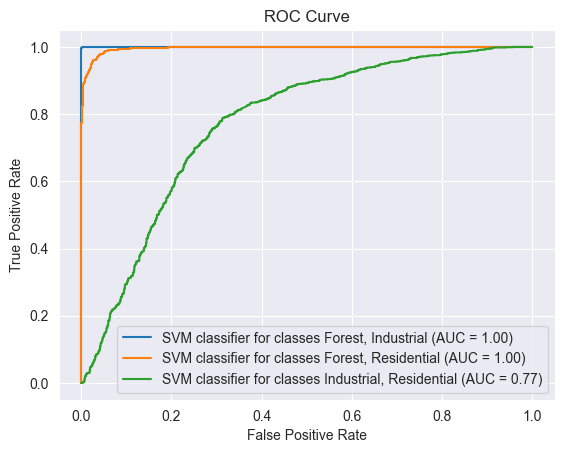

In [12]:
from itertools import combinations
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt


# Define a list of class combinations
class_combinations = combinations(set(labels), 2)

# Train and evaluate each binary SVM classifier
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    
    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1, probability=True, random_state=42)
    svm.fit(images_train_filtered, labels_train_filtered)

    # Calculate the probabilities of the positive class for the filtered test data
    y_prob = svm.predict_proba(images_test_filtered)[:, 1]

    # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(labels_test_filtered, y_prob, pos_label=classes[1])

    # Calculate the AUC for the ROC curve
    auc_score = auc(fpr, tpr)
    
    # Plot the ROC curve for the current binary SVM classifier
    plt.plot(fpr, tpr, label="SVM classifier for classes %s, %s (AUC = %.2f)" % (classes[0], classes[1], auc_score))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

# Show the ROC curve plot
plt.show()

### S3: Multi-Class Classifiers via Majority Voting of Binary Classifiers

In [13]:
# Define a list of class combinations
class_combinations = combinations(set(labels), 2)

# Train and evaluate each binary SVM classifier
svm_classifiers = []
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]

    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1)
    svm.fit(images_train_filtered, labels_train_filtered)
    svm_classifiers.append(svm)

# Make predictions on the test data using each binary classifier
y_preds = []
for svm in svm_classifiers:
    y_pred = svm.predict(images_test)
    y_preds.append(y_pred)

# Combine the predictions using majority voting
y_pred_majority = []
for i in range(len(images_test)):
    class_votes = {}
    for y_pred in y_preds:
        pred_class = y_pred[i]
        if pred_class not in class_votes:
            class_votes[pred_class] = 0
        class_votes[pred_class] += 1
    majority_class = max(class_votes, key=class_votes.get)
    y_pred_majority.append(majority_class)

# Compute the classification accuracy
num_correct = sum([1 if y_pred == y_true else 0 for y_pred, y_true in zip(y_pred_majority, labels_test)])
accuracy = num_correct / len(labels_test)
print(f"Classification accuracy: {accuracy}")

Classification accuracy: 0.8014705882352942


### S4: Multi-Class Classifiers via Random-Forest Classifier

In [14]:
# using random forest classifier on images_train, images_test, labels_train, labels_test

from sklearn.ensemble import RandomForestClassifier

# Create and train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(images_train, labels_train)

# Evaluate the classifier on the test data
y_pred = rf.predict(images_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(labels_test, y_pred)

# Print the accuracy
print("Random Forest Classifier Accuracy:", accuracy)

Random Forest Classifier Accuracy: 0.9064705882352941


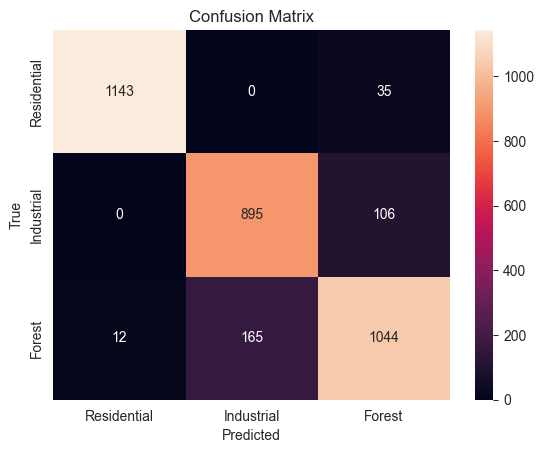

In [15]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix');

### S5: Fully-Connected Neural Network

Implement a deep learning model with fully connected layers using a single intermediate layer with 128 nodes.

I'm using one-hot encoding here to convert string labels to categorical labels that can be used in the neural network.

In [16]:
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils import to_categorical

batch_size = 128
num_classes = 3
epochs = 20

from sklearn.preprocessing import LabelEncoder

# create label encoder
le = LabelEncoder()

# fit label encoder and transform labels
labels_train_int = le.fit_transform(labels_train)
labels_test_int = le.transform(labels_test)

# convert integer-encoded labels to one-hot encoded labels
labels_train_onehot = to_categorical(labels_train_int, num_classes)
labels_test_onehot = to_categorical(labels_test_int, num_classes)

model = Sequential()

model.add(Dense(128, input_shape=(4096,), activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Here, we'll visualize the model using keras.

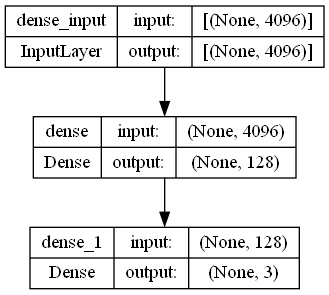

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
import keras
import tensorflow as tf

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(images_train, labels_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(images_test, labels_test_onehot))

Epoch 1/20
40/40 [==============================] - 1s 11ms/step - loss: 1.2236 - accuracy: 0.3643 - val_loss: 1.1589 - val_accuracy: 0.2809
Epoch 2/20
40/40 [==============================] - 0s 9ms/step - loss: 1.1344 - accuracy: 0.3106 - val_loss: 1.1108 - val_accuracy: 0.3509
Epoch 3/20
40/40 [==============================] - 0s 9ms/step - loss: 1.1056 - accuracy: 0.3280 - val_loss: 1.0941 - val_accuracy: 0.3297
Epoch 4/20
40/40 [==============================] - 0s 9ms/step - loss: 1.0936 - accuracy: 0.3063 - val_loss: 1.0858 - val_accuracy: 0.3303
Epoch 5/20
40/40 [==============================] - 0s 9ms/step - loss: 1.0875 - accuracy: 0.2992 - val_loss: 1.0808 - val_accuracy: 0.3376
Epoch 6/20
40/40 [==============================] - 0s 10ms/step - loss: 1.0829 - accuracy: 0.3208 - val_loss: 1.0761 - val_accuracy: 0.3365
Epoch 7/20
40/40 [==============================] - 0s 9ms/step - loss: 1.0780 - accuracy: 0.3169 - val_loss: 1.0715 - val_accuracy: 0.3482
Epoch 8/20
40/40 [

In [20]:
score = model.evaluate(images_test, labels_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.029808759689331
Test accuracy: 0.44294118881225586


### S6: Variations of Network Architectures

Compare the previous network to an alternative one using 4 intermediate layers with 32 nodes in each.

In [0]:
model_two = Sequential()

model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
model_two.add(Dense(num_classes, activation='softmax'))

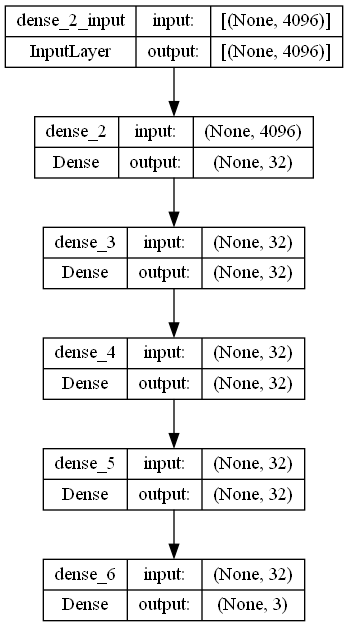

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model_two, show_shapes=True, show_layer_names=True)

In [21]:

model_two.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_two.fit(images_train, labels_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(images_test, labels_test_onehot))

score = model_two.evaluate(images_test, labels_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
40/40 [==============================] - 1s 7ms/step - loss: 1.1336 - accuracy: 0.3573 - val_loss: 1.1299 - val_accuracy: 0.3465
Epoch 2/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1246 - accuracy: 0.3573 - val_loss: 1.1224 - val_accuracy: 0.3465
Epoch 3/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1181 - accuracy: 0.3573 - val_loss: 1.1171 - val_accuracy: 0.3465
Epoch 4/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1111 - accuracy: 0.3573 - val_loss: 1.1112 - val_accuracy: 0.3465
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1090 - accuracy: 0.3573 - val_loss: 1.1093 - val_accuracy: 0.3465
Epoch 7/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1078 - accuracy: 0.3573 - val_loss: 1.1082 - val_accuracy: 0.3465
Epoch 8/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1070 - accuracy: 0.3573 - val_loss: 1.1073 - val_accuracy: 0.3465
Epoch 9/20
40/40 [==

#### Q6.1: Which network has more parameters to learn? How many more parameters?

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 524,803
Trainable params: 524,803
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                131104    
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 134,371
Trainable params: 134,371
Non-trainable params: 0
_________________________________________________________________


According to these summaries, the first model with 128 nodes has 524,416 parameters to learn, while the second model with 4 layers of 32 nodes each has 131,104 parameters to learn. This means that the first model has 393,312 more parameters to learn than the second model.

#### Q6.2: Which network has a higher validation accuracy?

It looks like the network with only 1 layer and 128 nodes has a higher validation accuracy (0.454) than the network with 4 layers and 32 nodes each (0.376).